In [53]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
#from preprocessing import get_ticker
from config import api_key
import os

In [62]:
def get_ticker(ticker):
    stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?seriestype=line&apikey={api_key}')
    stock = stock.json()
    stock = stock['historical']
    stock = pd.DataFrame.from_dict(stock)
    stock['date'] = pd.to_datetime(stock['date'])
    stock.set_index('date', inplace=True)
    return stock

In [63]:
stock = get_ticker('TGT')

In [64]:
stock.head()

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2020-09-01,150.610001,151.770004,150.119995,150.550003,150.550003,3519286.0,3519286.0,-0.06000,-0.040,150.81333,"September 01, 20",-0.00040
2020-08-31,151.139999,151.910004,150.320007,151.210007,151.210007,3021800.0,3021800.0,0.07001,0.046,151.14667,"August 31, 20",0.00046
2020-08-28,150.309998,151.669998,149.600006,150.850006,150.850006,2835000.0,2835000.0,0.54001,0.359,150.70667,"August 28, 20",0.00359
2020-08-27,152.660004,152.750000,149.669998,150.309998,150.309998,3773100.0,3773100.0,-2.35001,-1.539,150.91000,"August 27, 20",-0.01539
2020-08-26,152.750000,153.570007,152.089996,152.710007,152.710007,3061600.0,3061600.0,-0.03999,-0.026,152.79000,"August 26, 20",-0.00026


In [65]:
stock.to_csv('target_stockprices.csv')

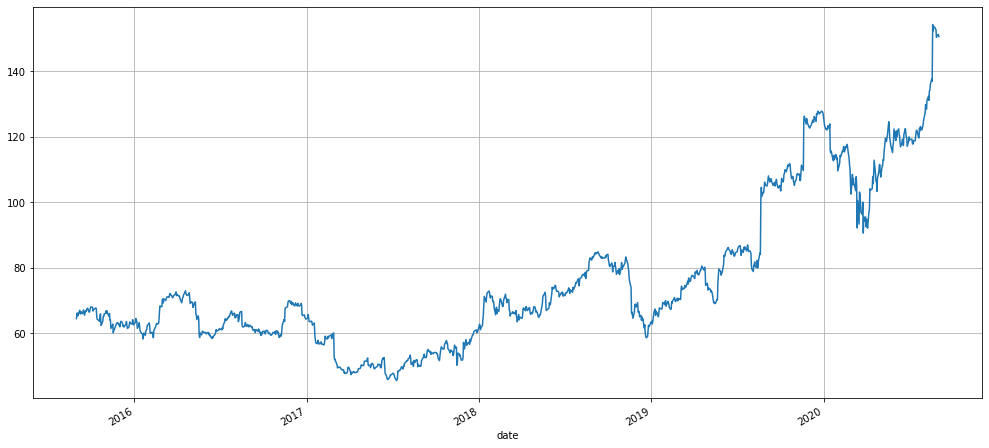

In [68]:
fig = plt.figure(figsize= (17, 8))
stock['adjClose'].plot()
plt.grid()
plt.show()

# Multi Period Returns

In [7]:
target_close = pd.DataFrame(stock['adjClose'])
target_returns = target_close.rename(columns={'adjClose': 'close'})

In [8]:
#Daily Returns
target_returns['daily_returns'] = target_returns.close.pct_change().mul(100)

#Monthly Returns 
target_returns['monthly_returns'] = target_returns.close.pct_change(periods=30).mul(100)

#Annual Returns
target_returns['annual_returns'] = target_returns.close.pct_change(periods=360).mul(100)

<Figure size 1224x576 with 0 Axes>

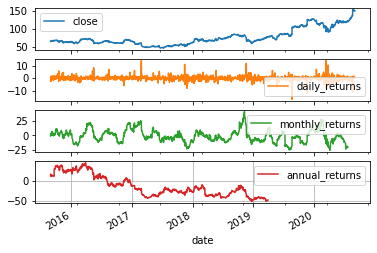

In [9]:
fig = plt.figure(figsize= (17, 8))
target_returns.plot(subplots=True)
plt.grid()
plt.show()

# Comparing stock prices with indexes as benchmarks

In [69]:
def index(index):
    djia = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/^{index}?apikey={api_key}')
    djia = djia.json()
    djia = djia['historical']
    djia = pd.DataFrame.from_dict(djia)
    djia['date'] = pd.to_datetime(djia['date'])
    djia.set_index('date', inplace=True)
    return djia

In [70]:
djia = index('DJI')
djia_close = pd.DataFrame(djia['adjClose'])
djia_close = djia_close.rename(columns={'adjClose': 'djia'})

In [14]:
sp500 = index('GSPC')
sp500_close = pd.DataFrame(sp500['adjClose'])
sp500_close = sp500_close.rename(columns={'adjClose': 'sp500'})

In [15]:
target_close = target_close.rename(columns={'adjClose': 'target'})

In [16]:
target_index = pd.concat([target_close, djia_close, sp500_close], axis=1)
target_index

,target,djia,sp500
date,,,
2015-09-01,64.450000,16058.349609,1913.849976
2015-09-02,65.870000,16351.379883,1948.859985
2015-09-03,66.210000,16374.759766,1951.130005
2015-09-04,65.330000,16102.379883,1921.219971
2015-09-08,67.010000,16492.679688,1969.410034
...,...,...,...
2020-08-26,152.710007,28331.919922,3478.729980
2020-08-27,150.309998,28492.269531,3484.550049
2020-08-28,150.850006,28653.869141,3508.010010


In [17]:
target_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2015-09-01 to 2020-09-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  1260 non-null   float64
 1   djia    1259 non-null   float64
 2   sp500   1260 non-null   float64
dtypes: float64(3)
memory usage: 39.4 KB


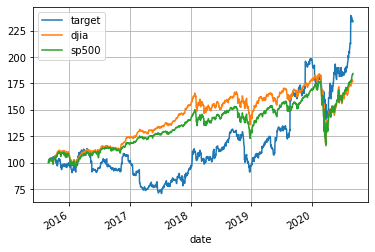

In [18]:
#Normalize and plot
target_index.div(target_index.iloc[0]).mul(100).plot()
plt.grid()
plt.show()

# Weekly, Monthly, and Annual Trends

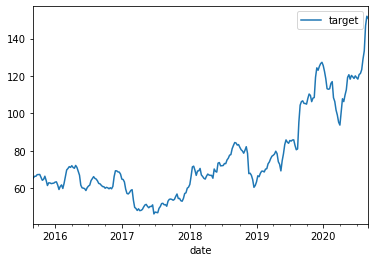

In [19]:
#Weekly trends
tgt_weekly = target_close.resample('W').mean()
tgt_weekly.plot()

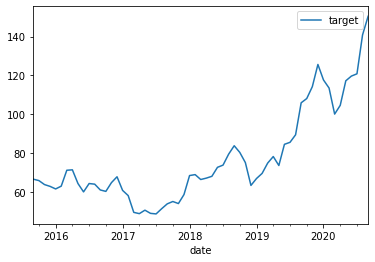

In [20]:
tgt_monthly = target_close.resample('M').mean()
tgt_monthly.plot()

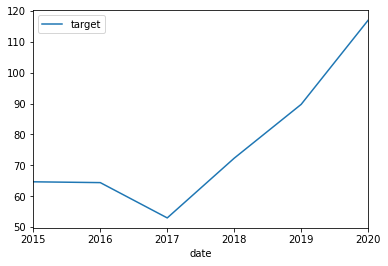

In [21]:
tgt_annual = target_close.resample('A').mean()
tgt_annual.plot()

In [22]:
tgt_trends = pd.concat([tgt_weekly, tgt_monthly, tgt_annual], axis=1)

# Monthly Mean, Median, and Standard Deviation

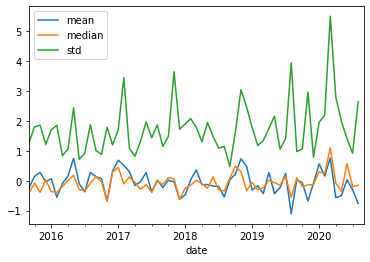

In [23]:
daily_returns = target_close.squeeze().pct_change().mul(100)
#Resample data and compile statistics
stats = daily_returns.resample('M').agg(['mean', 'median', 'std'])
stats.plot()

# Rolling Averages

In [24]:
daily_returns

date
2020-09-01         NaN
2020-08-31    0.465093
2020-08-28   -0.238080
2020-08-27   -0.357977
2020-08-26    1.596706
                ...   
2015-09-08    1.591874
2015-09-04   -2.507088
2015-09-03    1.347008
2015-09-02   -0.513518
2015-09-01   -2.155761
Name: target, Length: 1260, dtype: float64

In [25]:
target_close

,target
date,
2020-09-01,150.509995
2020-08-31,151.210007
2020-08-28,150.850006
2020-08-27,150.309998
2020-08-26,152.710007
...,...
2015-09-08,67.010000
2015-09-04,65.330000
2015-09-03,66.210000


# Monthly Stock Prices for Target, Costco, and Walmart

In [28]:
def stock(ticker):
    stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey=77d47c5d1debc07182939544406223dc')
    stock = stock.json()
    stock = stock['historical']
    stock = pd.DataFrame.from_dict(stock)
    stock['date'] = pd.to_datetime(stock['date'])
    stock.set_index('date', inplace=True)
    return stock

In [29]:
costco = stock('COST')
costco = pd.DataFrame(costco['adjClose'])
costco_close = costco.rename(columns={'adjClose': 'costco'})

In [30]:
walmart = stock('WMT')
walmart = pd.DataFrame(walmart['adjClose'])
walmart_close = walmart.rename(columns={'adjClose': 'walmart'})

In [31]:
retail = pd.concat([target_close, costco_close, walmart_close], axis=1)

In [32]:
retail

,target,costco,walmart
date,,,
2020-09-01,150.509995,351.380005,147.589996
2020-08-31,151.210007,347.660004,138.850006
2020-08-28,150.850006,348.369995,140.300003
2020-08-27,150.309998,346.359985,136.630005
2020-08-26,152.710007,344.269989,130.699997
...,...,...,...
2015-09-08,67.010000,129.260000,59.180000
2015-09-04,65.330000,126.570000,56.960000
2015-09-03,66.210000,128.390000,57.830000


In [33]:
#Correlation matrix over the last 5 years
retail_corr = retail.corr()
retail_corr

,target,costco,walmart
target,1.000000,0.902219,0.837152
costco,0.902219,1.000000,0.961371
walmart,0.837152,0.961371,1.000000


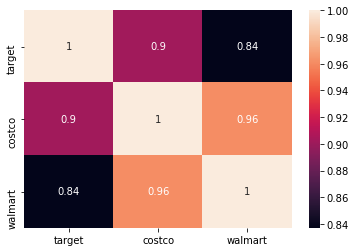

In [34]:
sns.heatmap(retail_corr, annot=True)

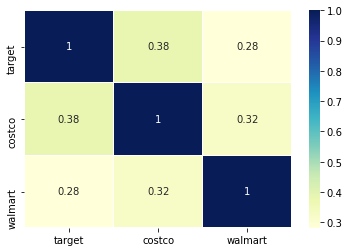

In [35]:
#Monthly Correations amoung these retail stores

#Calculate end of year prices
monthly_prices = retail.resample('M').last()

#Annual returns
monthly_returns = monthly_prices.pct_change().mul(100)

correlation = monthly_returns.corr()
sns.heatmap(correlation,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 10})

In [36]:
monthly_prices

,target,costco,walmart
date,,,
2015-09-30,67.250000,132.130000,57.810000
2015-10-31,65.980000,144.520000,51.030000
2015-11-30,62.470000,147.910000,52.460000
2015-12-31,62.560000,147.990000,55.110000
2016-01-31,62.400000,138.480000,59.660000
...,...,...,...
2020-05-31,122.330000,308.470000,124.060000
2020-06-30,119.930000,303.209991,119.779999
2020-07-31,125.260796,325.529999,128.870193


In [37]:
monthly_returns.round(3)

,target,costco,walmart
date,,,
2015-09-30,NaN,NaN,NaN
2015-10-31,-1.888,9.377,-11.728
2015-11-30,-5.320,2.346,2.802
2015-12-31,0.144,0.054,5.051
2016-01-31,-0.256,-6.426,8.256
...,...,...,...
2020-05-31,12.065,1.805,2.512
2020-06-30,-1.962,-1.705,-3.450
2020-07-31,4.445,7.361,7.589


In [38]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2020-09-01 to 2015-09-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   1260 non-null   float64
 1   costco   1260 non-null   float64
 2   walmart  1260 non-null   float64
dtypes: float64(3)
memory usage: 79.4 KB


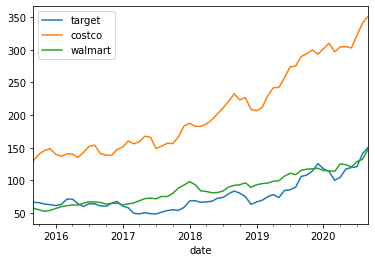

In [39]:
retail_monthly_avg = retail.resample('M').mean()
retail_monthly_avg.plot()
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd214c00130>,
      dtype=object)

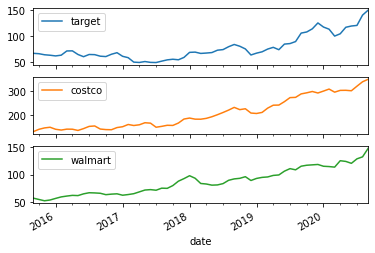

In [40]:
retail_monthly_avg.plot(subplots=True)

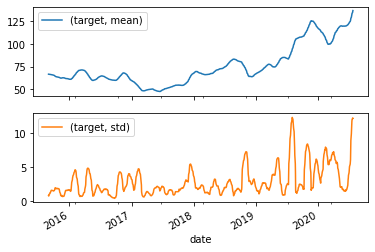

In [41]:
#Get the 30 day moving average and standard deviation of Target
rolling_stats = target_close.rolling(window=30).agg(['mean', 'std'])
rolling_stats.plot(subplots=True)
plt.show()

# Cumulative Return Formula
(Current Price of Security)−(Original Price of Security) / Original Price of Security

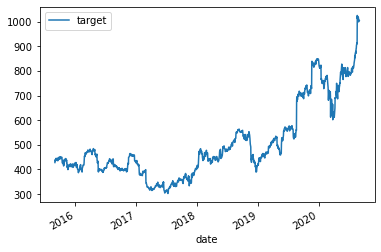

In [42]:
#How much did you invest 5 years ago
investment = 1000

#Get daily returns
daily_returns = target_close.pct_change()

#Get the cumulative return 
returns = daily_returns +1
cumulative_return = returns.cumprod()

#Calculate and plot investment
cumulative_return.mul(investment).plot()

In [43]:
cumulative_return

,target
date,
2020-09-01,NaN
2020-08-31,1.004651
2020-08-28,1.002259
2020-08-27,0.998671
2020-08-26,1.014617
...,...
2015-09-08,0.445220
2015-09-04,0.434058
2015-09-03,0.439904


In [44]:
returns

,target
date,
2020-09-01,NaN
2020-08-31,1.004651
2020-08-28,0.997619
2020-08-27,0.996420
2020-08-26,1.015967
...,...
2015-09-08,1.015919
2015-09-04,0.974929
2015-09-03,1.013470
